In [1]:
! pip install --quiet gensim

In [2]:
import pandas as pd
yelps = pd.read_csv('sentiment/yelps.csv')

In [3]:
yelps = yelps.sample(frac=1).reset_index(drop=True)

In [4]:
from bs4 import BeautifulSoup
import re

def clean_yelp(s):
    s = BeautifulSoup(s, 'html5lib').get_text()
    s = ' '.join(s.split())
    s = s.strip().lower()
    return s

def tokenize(s):
    """ Returns a list of strings (tokens) from the document """
    # Implement this function!
    # Hint: If you look at the sklearn source code on github, 
    # you will find a good regular expression they use as a default
    # tokenizer in CountVectorizer -- this is the tokenizer
    # we have been using until now!
    # But you need to implement your own now. 
    
    # define pattern
    pattern = r"(?u)\b\w\w+\b"
    
    # compile pattern
    pattern = re.compile(pattern)
    
    # return all expressions in s that match pattern
    return(pattern.findall(s))
    pass

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

# Create a count vectorizer, using the preprocessor and tokenizer from above
# use TruncatedSVD from Sklearn to generate a term embedding matrix for your data
# that is 100 dimensional in size.
# Embed your documents via that term embedding matrix (this is just the PCA of the 
# TF matrix, as returned by "transform" on TruncatedSVD

# Here you should have TWO vector representations of your Yelp data: 
# 1. The original TF matrix
# 2. The first 100 components of the PCA of that matrix, as performed by TruncatedSVD

# Initialise the count vectorizer using my own preprocessing
countvectorizer = CountVectorizer(tokenizer= tokenize, preprocessor = clean_yelp)

# fit it on the document list to create a tf matrix
tfmatrix = countvectorizer.fit_transform(yelps.text)                                  

# initialise SVD with 100 comps
svd = TruncatedSVD(n_components=100)  

# fit on the TF matrix
svd_fitted = svd.fit_transform(tfmatrix)                                              

/Users/seb/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:273: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/Users/seb/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:336: UserWarning: "https://www.consumeraffairs.com/news/mypillow-gets-a-rude-awakening-as-the-better-business-bureau-gives-it-an-f-010517.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [6]:
# check the fitted svd
svd_fitted

array([[ 1.35316845e+01,  3.69565045e+00,  4.82731072e-01, ...,
        -1.02896899e+00,  3.59163552e-01,  1.92657721e-01],
       [ 7.78211034e+00,  2.28608061e+00, -1.06978500e-01, ...,
         1.98425486e-01,  3.68446803e-01, -1.52583737e-01],
       [ 6.60250093e+00,  1.94286342e+00, -2.06585673e+00, ...,
        -6.39764653e-01,  1.98563650e-02,  1.11882177e-01],
       ...,
       [ 6.82628536e+00,  3.01660716e+00, -3.75522642e-01, ...,
         1.54342716e-01, -3.38550276e-01, -2.85593225e-01],
       [ 5.86232294e-01, -2.39405325e-01, -1.68909270e-01, ...,
         9.76840134e-02,  1.46725513e-01, -4.74790637e-02],
       [ 1.56055437e+00, -5.10371927e-03, -6.05547717e-01, ...,
         1.26502946e-01,  1.43908709e-01, -1.74864375e-01]])

In [7]:
# check the tf matrix
tfmatrix

<100000x78364 sparse matrix of type '<class 'numpy.int64'>'
	with 7381816 stored elements in Compressed Sparse Row format>

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

def test_holdout_vectors(V, y, cutoff):
    model = LogisticRegression(solver = 'newton-cg')
    model.fit(V[:cutoff], y[:cutoff])
    preds = model.predict(V[cutoff:])
    return accuracy_score(preds, y[cutoff:])

In [9]:
# Test your vector representations using the above function, test_holdout_vectors. 
# for several levels of "cutoff". 

# This function simulates training on a small part of your data and testing on the rest.
# Thus, it's as though you have some labelled data but a bunch of unlabelled data. 
# This is essentially a semi-supervised situation. 

# Do the word embeddings generated via SVD allow you to pull information from the 
# unlabeled data and improve your score given a small training set? 

# define a range of cutoffs
cutoffs = [100, 250, 500, 1000, 5000, 10000, 25000, 50000, 75000]

# use the tf matrix as features to predict the sentiment in the reviews using logistic regression
tfmatrix_results = [test_holdout_vectors(tfmatrix, yelps.positive, i) for i in cutoffs]

# try the same using the svd embeddings
truncsvd_results = [test_holdout_vectors(svd_fitted, yelps.positive, i) for i in cutoffs]

In [10]:
from matplotlib import pyplot as plt

# plot the two different attempts for varying cutoffs
plt.plot(cutoffs, tfmatrix_results)
plt.plot(cutoffs, truncsvd_results)
plt.legend(['Full TF Matrix', '100 Dim via SVD'])
plt.xscale("log")
plt.show()

<Figure size 640x480 with 1 Axes>

In [11]:
from gensim.models import Word2Vec

# Next, create another term embedding via Word2Vec, also 100 dimensional
# Look at the documentation from the library gensim and see what hyperparameters
# you can choose to tune. 
# Note: training takes time, so you probably won't want to try too many!

# pass the cleaned and tokenized yelp reviews as "sentences" to your model
# to build the vocabulary and train the word vectors. 

# tokenize the invididual reviews
sentences = [tokenize(clean_yelp(i)) for i in yelps.text]

# try a model with a small minimum frequency first
model = Word2Vec(sentences, size=100, window=5, min_count=1, workers=8)
model.train(sentences, total_examples=1, epochs=2)

# also try a model with a larger window of ngrams
model2 = Word2Vec(sentences, size=100, window=10, min_count=1, workers=8)
model2.train(sentences, total_examples=1, epochs=2)

# also try a model with a larger minimum frequency
model3 = Word2Vec(sentences, size=100, window=5, min_count=5, workers=8)
model3.train(sentences, total_examples=1, epochs=2)

/Users/seb/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:273: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/Users/seb/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:336: UserWarning: "https://www.consumeraffairs.com/news/mypillow-gets-a-rude-awakening-as-the-better-business-bureau-gives-it-an-f-010517.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


(16972873, 22344184)

In [12]:
# use the embed_w2v function to embed your Yelp reviews using the new
# word2vec word embeddings. Each review will be a normalized sum of the
# words that it is made of. 
# See how this improves the scores in the classification task using
# test_holdout_vectors -- is word2vec better? At what training-set sizes does it help
# more? 

import numpy as np

def embed_w2v(tokens, w2v):
    idxs = [w2v.wv.vocab.get(t) for t in tokens]
    idxs = [t.index for t in idxs if t]
    N = w2v.wv.vectors.shape[1]
    if len(idxs) < 1:
        return np.zeros(N)
    a = np.sum(w2v.wv.vectors[idxs, :], axis=0) 
    a /= np.linalg.norm(a)
    return a

In [13]:
# use each model in turn to embed the individual reviews
w2v_matrix1 = np.array([embed_w2v(t, model) for t in sentences])
# then train the Logistic Regression model using these features and predict
w2v_results1 = [test_holdout_vectors(w2v_matrix1, yelps.positive, i) for i in cutoffs]

w2v_matrix2 = np.array([embed_w2v(t, model2) for t in sentences])
w2v_results2 = [test_holdout_vectors(w2v_matrix2, yelps.positive, i) for i in cutoffs]

w2v_matrix3 = np.array([embed_w2v(t, model3) for t in sentences])
w2v_results3 = [test_holdout_vectors(w2v_matrix3, yelps.positive, i) for i in cutoffs]

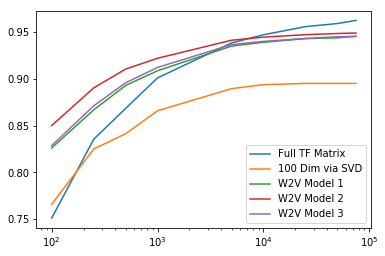

In [14]:
# plot the results against previous TF and SVD predictions
plt.plot(cutoffs, tfmatrix_results)
plt.plot(cutoffs, truncsvd_results)
plt.plot(cutoffs, w2v_results1)
plt.plot(cutoffs, w2v_results2)
plt.plot(cutoffs, w2v_results3)
plt.legend(['Full TF Matrix', '100 Dim via SVD', 'W2V Model 1', 'W2V Model 2', 'W2V Model 3'])
plt.xscale("log")
plt.show()

LR using W2V is the best model (almost over the whole range), and most dominant at small sample sizes! Larger windows work better than smaller windows, the min word frequency parameter's effect is minimal. The whole TF matrix outperforms the SVD matrix as features at almost any sample size, except for very small samples.

In [15]:
import pandas as pd
import re
from functools import reduce

pats = [re.compile(r'https?:\/\/[^\s]+'), 
        re.compile(r'rt\s*@\w+\s?:?'),
        re.compile(r'@\w+')]

def clean_twitter(s):
    """ Cleans Twitter specific issues
    
    Should probably clean out mentions, URLs, and RT's.
    """
    s = s.lower()
    _sub = lambda s,pat: re.sub(pat, '', s)
    s = reduce(_sub, pats, s)
    s = ' '.join(s.split()).strip()
    # TODO: Use regular expressions to remove unwanted
    # text and clean up our tweets to be more usable!

    # BONUS: Try using the library "spacy" to 
    # do further processing, such as lemmatizing
    # or replacing Named Entities with constants (i.e. "[NAMED]")
    # or adding the part of speech or dependency code to the word 

    return s

In [16]:
# Load tweet!
# NOTE: this file needs to be downloaded from Box! 

with open('tweets/tweets.txt') as f:
    tweets = pd.Series(f.readlines())

In [17]:
# Now embed this twitter data, again using Word2Vec and LSA (SVD)
# you don't have any labels, but you might be able to 
# find some interesting phenomena. 

# get the TF matrix for tweets
tweetvectorizer = CountVectorizer(tokenizer= tokenize, preprocessor = clean_twitter) 
tfmatrix_tweets = tweetvectorizer.fit_transform(tweets)    

# get the SVD matrix for tweets
svd_tweets = TruncatedSVD(n_components=100)  
svd_fitted_tweets = svd_tweets.fit_transform(tfmatrix_tweets)  

In [18]:
# tokenize for the W2V model
tweet_tokens = [tokenize(clean_twitter(i)) for i in tweets]

# initialise the model
model4 = Word2Vec(tweet_tokens, size=100, window=10, min_count=5, workers=8)

# train it
model4.train(sentences, total_examples=1, epochs=2)

(18127153, 22344184)

In [19]:
# Explore using either or both of the following tools: 
# 1. Word2Vec has a built in feature for getting most similar
# words, including via positive/negative examples (subtraction)
# What happens when you subtract "hillary" from "trump"? 

# What are the new embeddings?
w2v_matrix4 = np.array([embed_w2v(t, model4) for t in tweet_tokens])

In [20]:
display(model4.wv.most_similar('trump'))
display(model4.wv.most_similar('hillary'))
display(model4.wv.most_similar(positive=['trump'], negative=['hillary']))

[('trumps', 0.6764289140701294),
 ('gop', 0.5465739965438843),
 ('him', 0.5446867942810059),
 ('he', 0.5166928768157959),
 ('the', 0.5121273994445801),
 ('bernie', 0.5086058378219604),
 ('obama', 0.50635826587677),
 ('republican', 0.4843980669975281),
 ('republicans', 0.47458523511886597),
 ('that', 0.4715021550655365)]

[('hrc', 0.6688753366470337),
 ('hilary', 0.6605067253112793),
 ('sanders', 0.6555474400520325),
 ('chelsea', 0.620112419128418),
 ('crookedhillary', 0.6004730463027954),
 ('she', 0.6001008749008179),
 ('hilliary', 0.5924136638641357),
 ('killary', 0.5732863545417786),
 ('foundation', 0.5635843276977539),
 ('her', 0.5433469414710999)]

[('trumps', 0.4317951202392578),
 ('tusk', 0.4246476888656616),
 ('eiffel', 0.42209291458129883),
 ('francis', 0.4055992364883423),
 ('steve', 0.40080875158309937),
 ('south', 0.36954307556152344),
 ('incoming', 0.36498865485191345),
 ('mexican', 0.36348140239715576),
 ('vice', 0.35860002040863037),
 ('diego', 0.34122005105018616)]

Quite interestingly, the words most similar to the difference between trump and hillary mostly make sense: trump was the incoming president, whereas hillary was not. trump had a vice president, whereas hillary did not, etc.

In [21]:
# Bonus: build a similar feature for your LSA features and
# see if you can do similar vector math

from sklearn.metrics.pairwise import cosine_similarity

trump, hillary = 'trump','hillary'

# load full vocabulary
vocabulary = tweetvectorizer.vocabulary_
vocabulary_length = len(vocabulary)

# find words in dict
trump_idx, hillary_idx = list(vocabulary.keys()).index(trump), list(vocabulary.keys()).index(hillary)

# vectors with only chosen words...
trump_v, hillary_v = np.zeros(vocabulary_length), np.zeros(vocabulary_length)
trump_v[trump_idx], hillary_v[hillary_idx] = 1, 1

# transform using previously fit SVD
trump_lda = svd_tweets.transform(trump_v.reshape(1, -1))
hillary_lda = svd_tweets.transform(hillary_v.reshape(1, -1))

# vector difference
difference_lda = trump_lda - hillary_lda

In [22]:
vocab_list = list(vocabulary.keys())

def similarity(index, val, comparator, svd_f):
    v = np.zeros(vocabulary_length)
    v[index] = 1
    v_lda = svd_f.transform(v.reshape(1, -1))
    return val, cosine_similarity(comparator, v_lda)[0][0]

In [23]:
trump_lda_similar = [similarity(idx, val, trump_lda, svd_tweets) for idx, val in enumerate(vocab_list[:5000])]
trump_df = pd.DataFrame(trump_lda_similar, columns=['word', 'cos_sim']).sort_values('cos_sim', ascending=False)

In [24]:
hillary_lda_similar = [similarity(idx, val, hillary_lda, svd_tweets) for idx, val in enumerate(vocab_list[:5000])]
hillary_df = pd.DataFrame(hillary_lda_similar, columns=['word', 'cos_sim']).sort_values('cos_sim', ascending=False)

In [25]:
diff_lda_similar = [similarity(idx, val, difference_lda, svd_tweets) for idx, val in enumerate(vocab_list[:5000])]
diff_df = pd.DataFrame(diff_lda_similar, columns=['word', 'cos_sim']).sort_values('cos_sim', ascending=False)

In [31]:
print(trump_df[trump_df.cos_sim<0.99999].head(10))
print(hillary_df[hillary_df.cos_sim<0.99999].head(10))
print(diff_df[diff_df.cos_sim<0.99999].head(10))

             word   cos_sim
243          like  0.633145
3695        deeds  0.585972
308        europe  0.548591
3884           el  0.548190
3744       warned  0.540604
3666         tent  0.540604
2660        prote  0.540604
135       keeping  0.527203
361          used  0.491741
3214  citizenship  0.486928
             word   cos_sim
4408     sequitur  0.983200
3124  transgender  0.981821
1288       deploy  0.977259
4159       honest  0.973353
833        terror  0.968008
2869     godzilla  0.968008
4080        helps  0.923185
1924      lawfirm  0.894443
3434       leaker  0.875481
3474    recognize  0.874516
             word   cos_sim
55          trump  0.489620
243          like  0.376567
3514     proposal  0.284745
4126        smile  0.284745
3666         tent  0.276644
3744       warned  0.276644
2660        prote  0.276644
3884           el  0.275010
3818  disgraceful  0.256728
3695        deeds  0.253425


With some imagination, some of the words make sense, but mostly not. The SVD model captures embeddings much less well than the W2V!

In [28]:
# 2. Use the visualize_dist function to see how
# the tweet-tweet distance looks for a selection
# of random tweets. Do you agree with the distance? 
# Does one embedding seem better than another? 

In [54]:
from scipy.spatial.distance import pdist,squareform
import seaborn as sns

def visualize_dist(V, tweets, idxs):
    """ Visualize distances in heatmap

    V is the vector of embeddings 
    tweets is a list or series that converts from idx to tweet
    idxs is a list of integers that you would like to compare (<= 5 probably)
    """
    m = squareform(pdist(V[idxs], 'cosine'))
    _ = sns.heatmap(pd.DataFrame(m, columns = tweets[idxs], index= tweets[idxs]))

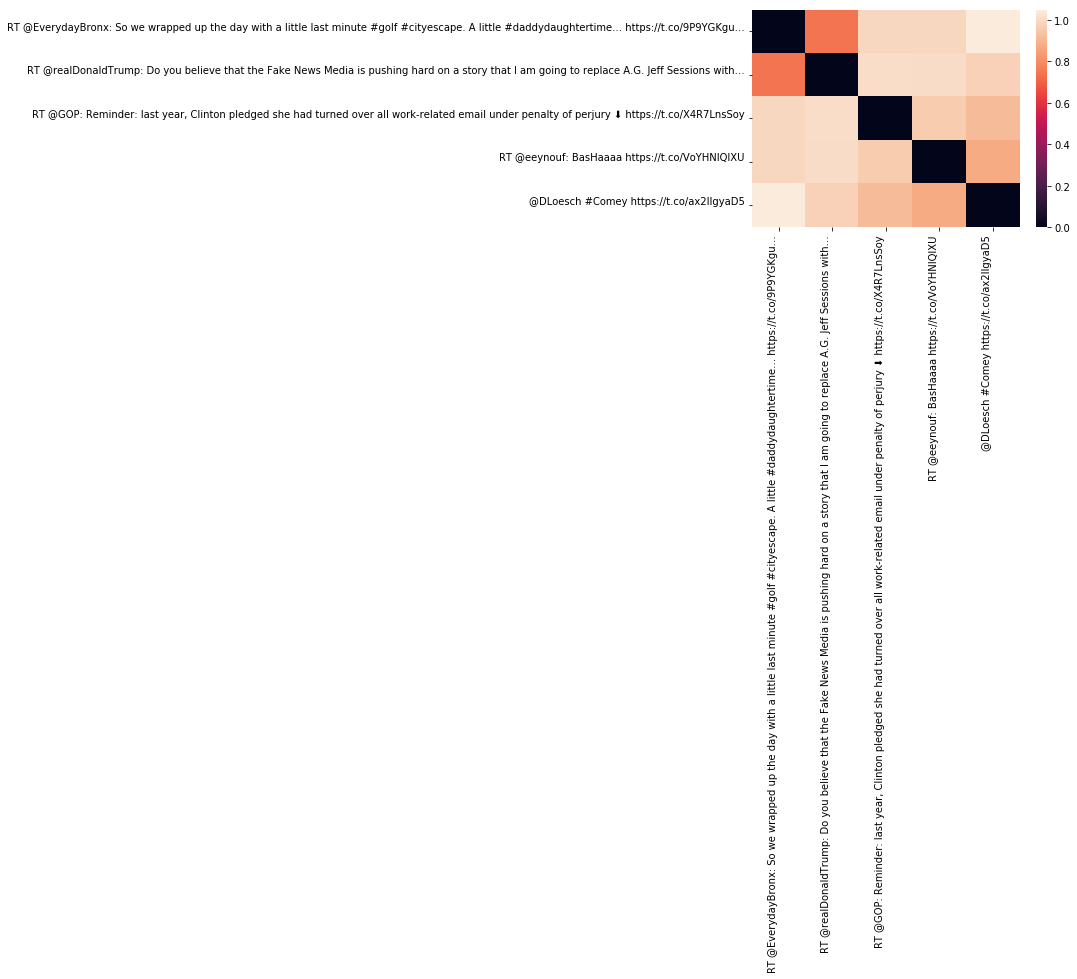

In [59]:
idx = np.random.randint(0, high=len(tweets), size=5)
visualize_dist(svd_fitted_tweets, tweets, idx)

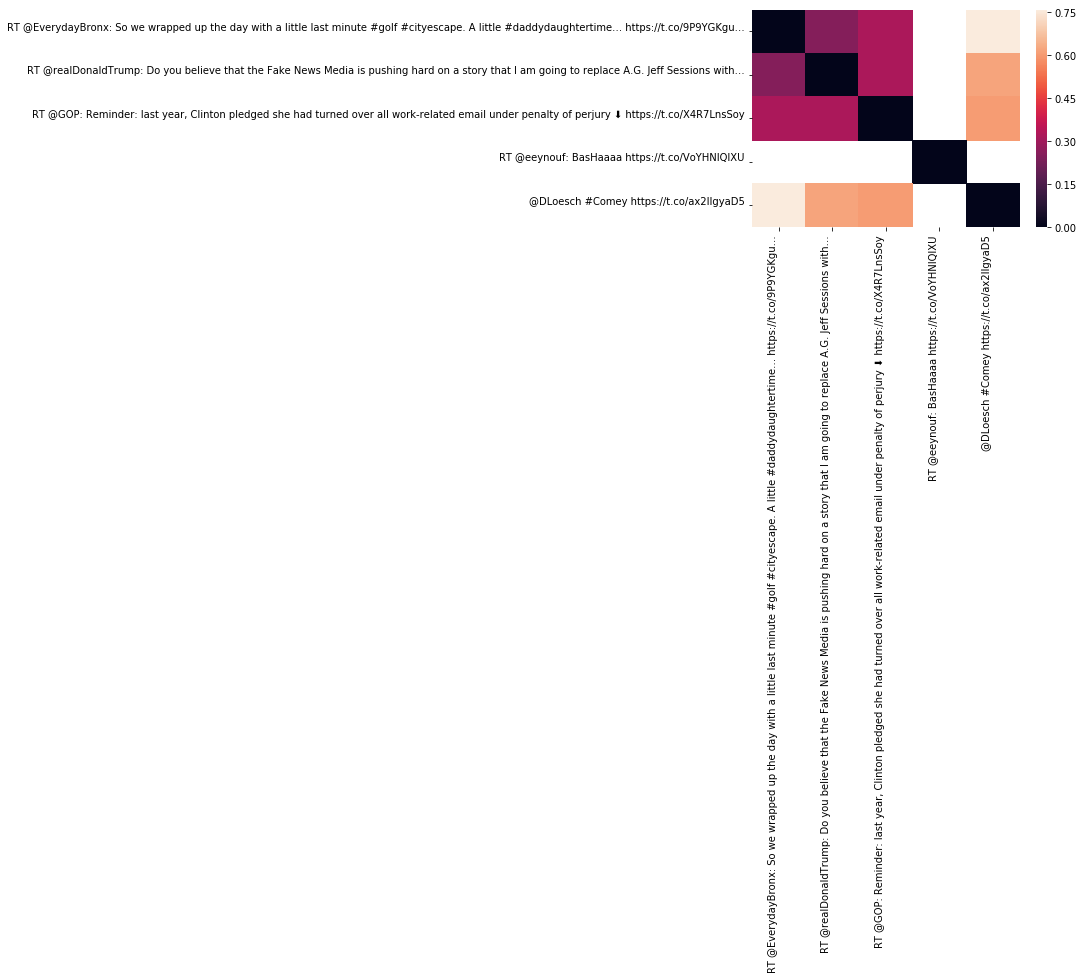

In [60]:
visualize_dist(w2v_matrix4, tweets, idx)

Both tweet distances seem somewhat sensible (fake news, lies about Hillary, golf playing president)! The SVD seems worse than the W2V embedding. 

In [58]:
# More bonus!
# Use one of the following pre-embedded models and see if your yelp scores improve? 
# What about your Twitter explorations?

# https://github.com/RaRe-Technologies/gensim-data
import gensim.downloader as api
model_google = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [61]:
# embed with google model
google_yelp = np.array([embed_w2v(t, model_google) for t in yelps.text.apply(clean_yelp).apply(tokenize)])

/Users/seb/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:273: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/Users/seb/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:273: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/Users/seb/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:336: UserWarning: "https://www.consumeraffairs.com/news/mypillow-gets-a-rude-awakening-as-the-better-business-bureau-gives-it-an-f-010517.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/seb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: 

In [62]:
google_yelp_results = [test_holdout_vectors(google_yelp, yelps.positive, i) for i in cutoffs]

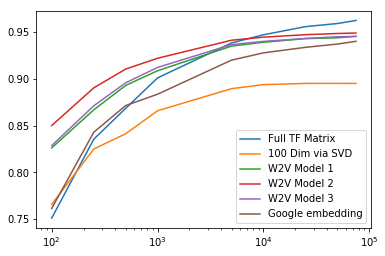

In [64]:
#plot all models
plt.plot(cutoffs, tfmatrix_results)
plt.plot(cutoffs, truncsvd_results)
plt.plot(cutoffs, w2v_results1)
plt.plot(cutoffs, w2v_results2)
plt.plot(cutoffs, w2v_results3)
plt.plot(cutoffs, google_yelp_results)
plt.legend(['Full TF Matrix', '100 Dim via SVD', 'W2V Model 1', 'W2V Model 2', 'W2V Model 3', 'Google embedding'])
plt.xscale("log")

/Users/seb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # This is added back by InteractiveShellApp.init_path()
/Users/seb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  del sys.path[0]
/Users/seb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()


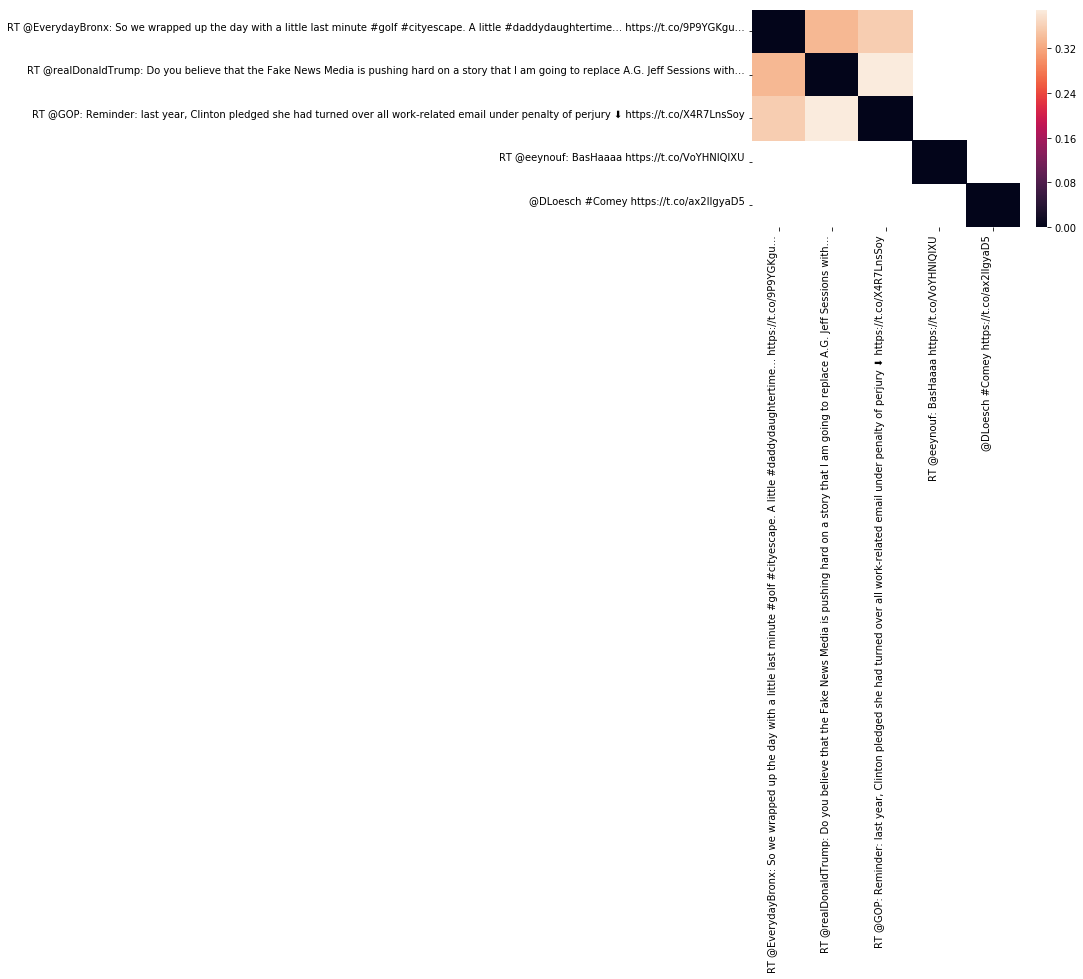

In [66]:
google_tweet = np.array([embed_w2v(t, model_google) for t in tweet_tokens])
visualize_dist(google_tweet, tweets, idx)

Our embeddings perform on par with google's embeddings! Of course they may perform more poorly out of domain, but for this application (yelp) we have trained quite good embeddings!